# Monoallelic Dataset Benchmark Evaluation

### Libraries

In [99]:
#analysis
import numpy as np
import pandas as pd
from typing import Union
#plotting
import matplotlib.pyplot as plt
from matplotlib import cm
#logging
import logging
logging.basicConfig(level=logging.DEBUG)
#enable logging debug
logging.disable(logging.DEBUG)

### Parameters

In [100]:
# input result dict generated by allele_associated_lookup_run_all_peptides.py (Option 1,2,3) or allele_associated_lookup_specific_wgibbs_run.py (Option 4,5)
# all result dicts are stored in the run folder
# best result for Option 5: run/allele_specific_wgibbs_run.txt
PATH_TO_RESULT_DICT = 'run/allele_specific_wgibbs_run.txt'

#SWITCH: ONLY_2DIGIT_EVALUATION
#True -> only the 2-digit evaluation is performed
#False ->  -> default: the 4-digit evaluation is performed
ONLY_2DIGIT_EVALUATION = False

### Load result dict from monoallelic dataset run

In [101]:
result_dict = {}
with open(PATH_TO_RESULT_DICT,'r') as f:
    result_dict = eval(f.read())
print(result_dict)

{'04-001': {'overall peptides in tuedb': 1610, 'peptide not in monoallelic ds': 1241, 'peptides': {'donor allele': {'A0101': 150, 'A2402': 113, 'B0801': 15, 'B1402': 74, 'C0701': 0, 'C0802': 1}, 'not donor allele': {'A2301': 5, 'A2902': 1, 'A6802': 1, 'C1402': 1, 'B2705': 3, 'A0207': 1, 'A2501': 1, 'A0201': 1, 'C0401': 1, 'B5703': 1}}}, '1003': {'overall peptides in tuedb': 2018, 'peptide not in monoallelic ds': 1564, 'peptides': {'donor allele': {'A0101': 125, 'A0201': 74, 'B5101': 180, 'B5701': 47, 'C0401': 5, 'C0602': 7}, 'not donor allele': {'C0303': 1, 'B5801': 3, 'A0207': 1, 'C0501': 1, 'B1501': 1, 'B2705': 1, 'C1505': 2, 'A6901': 1, 'A3201': 2, 'A2402': 1, 'A0205': 2}}}, '1008': {'overall peptides in tuedb': 1484, 'peptide not in monoallelic ds': 1189, 'peptides': {'donor allele': {'A0101': 97, 'A0201': 56, 'B0801': 36, 'B4001': 101, 'C0304': 0, 'C0701': 0}, 'not donor allele': {'C0303': 1, 'B1801': 1, 'B1501': 2, 'B4002': 1}}}, '1010': {'overall peptides in tuedb': 1866, 'pepti

### Functions

In [102]:
def generate_matching_counts(TOP_i: list) -> dict:
    matching_counts = {i: {'all': [], 'count_match_6': [], 'count_match_56': [], 'count_match_456': []} for i in TOP_i}
    return matching_counts

def generate_plot_dict(TOP_i: list) -> dict:
    plot = {i: {} for i in TOP_i}
    return plot

def make_dict_2digit(dict: dict) -> dict:
    new_dict = {}
    for key in dict:
        #add to it if it already exists
        if key[:3] in new_dict:
            new_dict[key[:3]] += dict[key]
        else:
            new_dict[key[:3]] = dict[key]
    return new_dict


def get_prediction_from_result_dict(combined_dict: dict, i: int) -> list:
    dict_a = {k: v for k, v in combined_dict.items() if k.startswith('A')}
    dict_a = sorted(dict_a.items(), key=lambda item: item[1], reverse=True)
    dict_b = {k: v for k, v in combined_dict.items() if k.startswith('B')}
    dict_b = sorted(dict_b.items(), key=lambda item: item[1], reverse=True)
    dict_c = {k: v for k, v in combined_dict.items() if k.startswith('C')}
    dict_c = sorted(dict_c.items(), key=lambda item: item[1], reverse=True)
    
    prediction = [key for key,_ in dict_a[:i]] + [key for key,_ in dict_b[:i]] + [key for key,_ in dict_c[:i]]

    return prediction

def evaluate_result_dict(donor: str, peptides_donor: dict, plot: dict, i: int) -> (Union[float,str], dict):

    if len(peptides_donor) < 4:
        logging.debug(f'The donor has 3 alleles (len(peptides_donor)<4), because donor has: {list(peptides_donor)}')
        return 'count_only_3_alleles',plot

    if len(peptides_donor) > 6:
        logging.debug(f'The donor has more than 6 alleles (len(peptides_donor)>6), because donor has: {list(peptides_donor)}')
        return 'count_more_than_6_alleles',plot
    
    logging.debug(f'There are {len(list(peptides_donor.keys()))} alleles for donor {donor}: {list(peptides_donor.keys())}')

    peptides_not_donor = result_dict[donor]['peptides']['not donor allele']

    if ONLY_2DIGIT_EVALUATION:
        peptides_not_donor = make_dict_2digit(peptides_not_donor)
        
    print_dict = {k: v for k, v in sorted(peptides_donor.items(), key=lambda item: item[1], reverse=True)}
    logging.debug(f'The counts of the peptides for donor alleles are: {print_dict}')
    print_dict_2 = {k: v for k, v in sorted(peptides_not_donor.items(), key=lambda item: item[1], reverse=True)}
    logging.debug(f'The counts of the peptides for non-donor alleles are: {print_dict_2}')
    
    combined_dict = {**peptides_donor, **peptides_not_donor}

    prediction = get_prediction_from_result_dict(combined_dict, i)
    

    if prediction == 'count_too_little_to_maj':
        return 'count_too_little_to_maj',plot
    
    list_donor_alleles = list(peptides_donor.keys())
    
    matching_count = 0
    
    alleles_a = [allele for allele in list_donor_alleles if allele.startswith('A')]
    alleles_b = [allele for allele in list_donor_alleles if allele.startswith('B')]
    alleles_c = [allele for allele in list_donor_alleles if allele.startswith('C')]
    prediction_a = [allele for allele in prediction if allele.startswith('A')]
    prediction_b = [allele for allele in prediction if allele.startswith('B')]
    prediction_c = [allele for allele in prediction if allele.startswith('C')]

    penalty = 0
    matching = 0
    
    if len(prediction_a) < len(alleles_a):
        penalty += len(alleles_a) - len(prediction_a)
    if len(prediction_a) == len(alleles_a):
        matching += len(set(list(prediction_a)).intersection(alleles_a))
    if len(prediction_a) > len(alleles_a):
        matching += len(set(prediction_a).intersection(alleles_a))


    if len(prediction_b) < len(alleles_b):
        penalty += len(alleles_b) - len(prediction_b)
    if len(prediction_b) == len(alleles_b):
        matching += len(set(list(prediction_b)).intersection(alleles_b))
    if len(prediction_b) > len(alleles_b):
        matching += len(set(prediction_b).intersection(alleles_b))


    if len(prediction_c) < len(alleles_c):
        penalty += len(alleles_c) - len(prediction_c)
    if len(prediction_c) == len(alleles_c):
        matching += len(set(list(prediction_c)).intersection(alleles_c))
    if len(prediction_c) > len(alleles_c):
        matching += len(set(prediction_c).intersection(alleles_c))

    for donor_allele in list_donor_alleles:
        if donor_allele in prediction:
            matching_count += 1

    logging.debug(f'Number of peptides that are matching: {matching_count} out of {len(list_donor_alleles)} donor alleles.')
    logging.debug(f'Number of peptides that are not matching: {(len(list_donor_alleles)-matching_count)} out of {len(list_donor_alleles)} donor alleles.')
    
    perc_matching = matching_count/len(list_donor_alleles)

    perc_matching = (matching - penalty) / len(list_donor_alleles)

    plot[i][donor] = {}
    plot[i][donor]['matching'] = (matching_count,len(list_donor_alleles))
    plot[i][donor]['pred and real alleles'] = [prediction,list_donor_alleles]

    return perc_matching, plot

### Main

In [103]:
#the analysis is performed for the best 2,3,4,5,6 alleles per loci
TOP_i = [2,3,4,5,6]

matching_counts = generate_matching_counts(TOP_i)

plot = generate_plot_dict(TOP_i)

count_only_3_alleles = []
count_over_6 = []
count_too_little_to_maj = []
count_tuedb_and_monoallelic = []

print(f'There are {len(list(result_dict.keys()))} donors in total.')

for i in TOP_i:

    for donor in result_dict:
        logging.debug(f'\nDonor: {donor}')

        #get data from result dict
        overall_peptides = result_dict[donor]['overall peptides in tuedb']
        not_in_mono = result_dict[donor]['peptide not in monoallelic ds']
        logging.debug(f'Overall peptides in tuedb for donor {donor}: {overall_peptides}')
        logging.debug(f'Overall peptides in tuedb that are also in monoallelic ds for donor {donor}: {overall_peptides - not_in_mono}')
        count_in_mono = (overall_peptides - not_in_mono)/overall_peptides
        logging.debug(f'Percent of tuedb peptides that are also in monoallelic dataset for donor {donor}: {round(count_in_mono*100,2)} %')
        
        peptides_donor = result_dict[donor]['peptides']['donor allele']
        
        if ONLY_2DIGIT_EVALUATION:
            peptides_donor = make_dict_2digit(peptides_donor)


        perc_matching, plot = evaluate_result_dict(donor, peptides_donor, plot, i)

        if perc_matching == 'count_only_3_alleles':
            count_only_3_alleles.append(donor)
        elif perc_matching == 'count_more_than_6_alleles':
            count_over_6.append(donor)
        else:
            if perc_matching == 'count_too_little_to_maj':
                count_too_little_to_maj.append(donor)
                perc_matching = 0
            else:
                count_tuedb_and_monoallelic.append(count_in_mono*100)
                plot[i][donor]['tdb and mono'] = overall_peptides - not_in_mono
                plot[i][donor]['how good'] = perc_matching

            if len(peptides_donor) == 6:
                matching_counts[i]['count_match_6'].append(perc_matching)
                matching_counts[i]['count_match_56'].append(perc_matching)
                matching_counts[i]['count_match_456'].append(perc_matching)
            if len(peptides_donor) == 5:
                matching_counts[i]['count_match_56'].append(perc_matching)
                matching_counts[i]['count_match_456'].append(perc_matching)
            if len(peptides_donor) == 4:
                matching_counts[i]['count_match_456'].append(perc_matching)

    logging.debug(f"There are {len(count_only_3_alleles)} donors that have only 3 alleles. They get thrown out.\ncount_only_3_alleles: {count_only_3_alleles} (with {len(count_only_3_alleles)} elements)\nThere are {len(count_over_6)} donors that have more than 6 alleles. They get thrown out.\ncount_over_6: {count_over_6} (with {len(count_over_6)} elements)\nThere are {len(count_too_little_to_maj)} donors that have less than 2 votes to majority vote for for at least one of the loci.\ncount_too_little_to_maj: {count_too_little_to_maj} (with {len(count_too_little_to_maj)} elements)")
    logging.debug(f"On average {round(np.sum(matching_counts[i]['count_match_6'])/len(matching_counts[i]['count_match_6']),3)*100} % of the donor alleles are matching for donors with 6 alleles.\nOn average {round(np.sum(matching_counts[i]['count_match_56'])/len(matching_counts[i]['count_match_56']),3)*100} % of the donor alleles are matching for donors with 5 or 6 alleles.")
    if i == 2:
        print(f"On average {int(round(np.sum(matching_counts[i]['count_match_456'])/len(matching_counts[i]['count_match_456']),2)*100)} % of the donor alleles are matching for donors with 4, 5 or 6 alleles.")
print(f"On average {int(round(np.sum(count_tuedb_and_monoallelic)/len(count_tuedb_and_monoallelic),0))} % of tuedb peptides are also allele-specific peptide.")


There are 778 donors in total.
On average 81 % of the donor alleles are matching for donors with 4, 5 or 6 alleles.


On average 19 % of tuedb peptides are also allele-specific peptide.


When you want so save the plot and read it in later:

In [104]:
#for SWITCH ON: TOP_i = [2]
#with open('save_plot_2.txt','w') as f:
    #f.write(str(plot))

#for SWITCH OFF: TOP_i = [2,3,4,5,6]
#with open('save_plot_23456.txt','w') as f:
    #f.write(str(plot))

# Plotting results
### Fetch allele frequencies for plotting

In [105]:
PATH_TO_ALLELE_FREQUENCY = '../../DATA/dkms_allele_freq_german.tsv'
PATH_TO_ALL_TUEDB_ALLELES = '../../DATA/all_tuedb_alleles.txt'


In [106]:
#read out the allele frequencies
allele_freq_df = pd.read_csv(PATH_TO_ALLELE_FREQUENCY, sep='\t')
allele_freq_dict = dict(zip(allele_freq_df['Allele'], allele_freq_df['Allele Frequency']))

#load txt file with all alleles from tuedb
all_tuedb_alleles = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)

# Update the allele_freq_dict with missing alleles and set frequency to 0
for allele in all_tuedb_alleles:
    allele_freq_dict.setdefault(allele, 0)

#allele that is not predicted by netmhcpan
allele_freq_dict['B*14:07'] = 0

sum_allele_freq_dict = sum(allele_freq_dict.values())
logging.debug(f'The sum of all entries should be rounded 3 (100% per locus): {sum_allele_freq_dict}')
print(f'The allele frequency dictionary looks like: {allele_freq_dict}')

The allele frequency dictionary looks like: {'A*01:01': 0.1537, 'A*01:02': 0.0001, 'A*01:03': 0.0003, 'A*01:06': 0.0001, 'A*01:09': 0.0, 'A*01:13': 0.0, 'A*01:14': 0.0, 'A*01:15N': 0.0, 'A*01:17': 0.0, 'A*01:21': 0.0, 'A*01:23': 0.0, 'A*01:25': 0.0, 'A*01:26': 0.0, 'A*01:29': 0.0, 'A*01:30': 0.0, 'A*01:35': 0.0, 'A*01:38': 0.0, 'A*01:39': 0.0, 'A*01:40': 0.0, 'A*01:41': 0.0, 'A*01:42': 0.0, 'A*01:43': 0.0, 'A*01:44': 0.0, 'A*01:49': 0.0, 'A*01:51': 0.0, 'A*01:57N': 0.0, 'A*01:61': 0.0, 'A*01:65': 0.0, 'A*01:66': 0.0, 'A*01:67': 0.0, 'A*01:68': 0.0, 'A*01:69': 0.0, 'A*01:72': 0.0, 'A*01:76': 0.0, 'A*01:77': 0.0, 'A*01:83': 0.0, 'A*01:86': 0.0, 'A*01:88': 0.0, 'A*01:89': 0.0, 'A*01:95': 0.0, 'A*01:98': 0.0, 'A*01:99': 0.0, 'A*01:100': 0.0, 'A*01:101': 0.0, 'A*01:106': 0.0, 'A*01:113': 0.0, 'A*01:115': 0.0, 'A*01:117': 0.0, 'A*01:118': 0.0, 'A*01:123N': 0.0, 'A*01:124': 0.0, 'A*01:126': 0.0, 'A*01:128': 0.0, 'A*01:136': 0.0, 'A*01:144': 0.0, 'A*01:157': 0.0, 'A*01:167': 0.0, 'A*01:170': 0

### Boxplot: Peptides in Tuedb and Monoallelic Ds vs. Accuracy Ranges (absolute y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_18128\1053395371.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


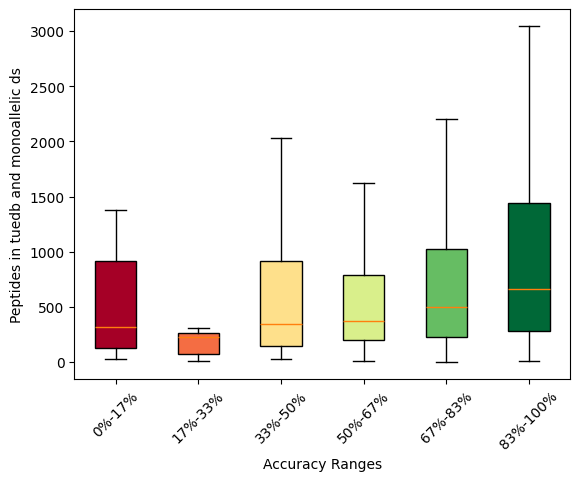

In [107]:
accuracy = []
no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    accuracy.append(plot1[donor]['matching'][0] / plot1[donor]['matching'][1])
    no_peptides.append(plot1[donor]['tdb and mono'])

num_buckets = 6
buckets = np.digitize(accuracy, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(no_peptides[i])

fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Accuracy Ranges')
plt.ylabel('Peptides in tuedb and monoallelic ds')
#plt.title('Peptides in Tuedb and Monoallelic Ds vs. Accuracy Ranges')
plt.show()

### Boxplot: Peptides in Tuedb and Monoallelic Ds vs. Accuracy Ranges (relative y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_18128\331192116.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


The correlation is 0.27874174844295274


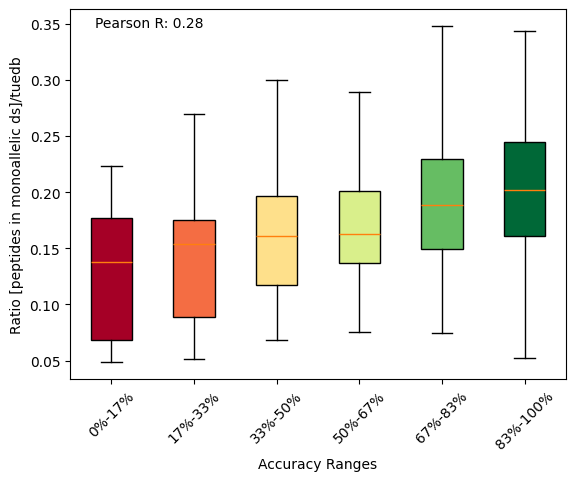

In [108]:
accuracy = []
rel_no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    accuracy.append(plot1[donor]['matching'][0] / plot1[donor]['matching'][1])
    rel_no_peptides.append(plot1[donor]['tdb and mono'] / result_dict[donor]['overall peptides in tuedb'])

num_buckets = 6
buckets = np.digitize(accuracy, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(rel_no_peptides[i])

fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

#percentages for 100
x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]	
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Accuracy Ranges')
plt.ylabel('Ratio [peptides in monoallelic ds]/tuedb')
#plt.title('Amount of Peptides in Tuedb and Accuracies')

correlation = np.corrcoef(accuracy, rel_no_peptides)[0, 1]
print('The correlation is', correlation)
plt.annotate(f'Pearson R: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()



### Boxplot: Allele Frequency of TueDB donors vs. Accuracy Ranges (relative y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_18128\2724933226.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


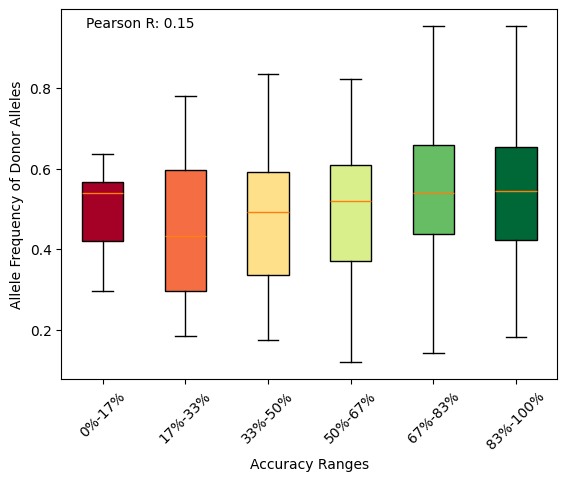

In [109]:
accuracy = []
donor_allele_frequency = []
colors = []

plot1 = plot[2]

for donor in plot1:
    accuracy.append(plot1[donor]['matching'][0] / plot1[donor]['matching'][1])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

num_buckets = 6
buckets = np.digitize(accuracy, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(donor_allele_frequency[i])

fig, ax = plt.subplots()
bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

#percentages out of 100
x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]	
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Accuracy Ranges')
plt.ylabel('Allele Frequency of Donor Alleles')
#plt.title('Allele Frequencies and Accuracies')

correlation = np.corrcoef(accuracy, donor_allele_frequency)[0, 1]
plt.annotate(f'Pearson R: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()

### Boxplot: Allele Frequency of TueDB donors vs. Peptides in TueDB and monoallelic dataset (absolute y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_18128\3700421676.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


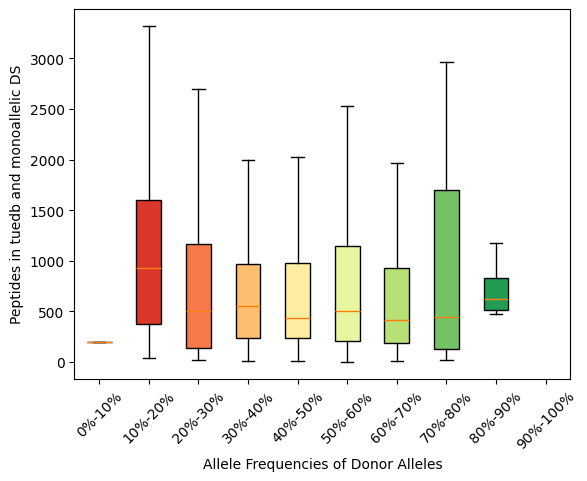

In [110]:
donor_allele_frequency = []
no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    no_peptides.append(plot1[donor]['tdb and mono'])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

num_buckets = 10
buckets = np.digitize(donor_allele_frequency, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(no_peptides[i])

# Create a boxplot for each bucket
fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]
ax.set_xticklabels(x_ranges)
#rotate x ticks
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Allele Frequencies of Donor Alleles')
plt.ylabel('Peptides in tuedb and monoallelic DS')
#plt.title('Allele Frequency and Peptides in TueDB and monoallelic DS')

# Show the plot
plt.show()

### Boxplot: Allele Frequency of TueDB donors vs. Peptides in TueDB and monoallelic dataset (relative y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_18128\972361063.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


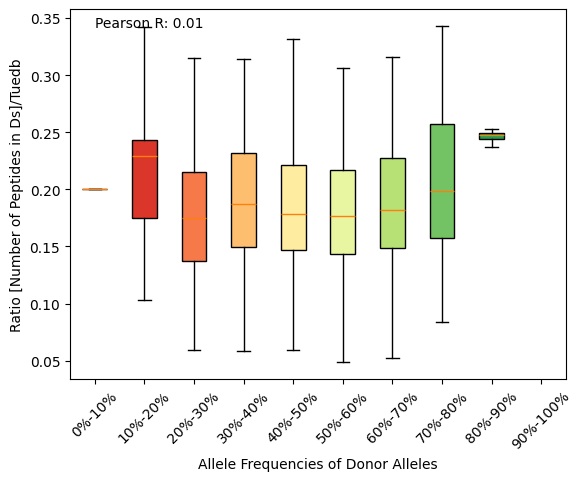

In [111]:
donor_allele_frequency = []
rel_no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    rel_no_peptides.append(plot1[donor]['tdb and mono'] / result_dict[donor]['overall peptides in tuedb'])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

num_buckets = 10
buckets = np.digitize(donor_allele_frequency, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(rel_no_peptides[i])

fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Allele Frequencies of Donor Alleles')
plt.ylabel('Ratio [Number of Peptides in Ds]/Tuedb')
#plt.title('Accuracy Ranges vs. Sum of Allele Frequencies of Donor Alleles')

correlation = np.corrcoef(donor_allele_frequency, rel_no_peptides)[0, 1]
plt.annotate(f'Pearson R: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()

### Scatter plot: Allele Frequency of TueDB donors vs. Peptides in TueDB and monoallelic dataset (relative y axis)

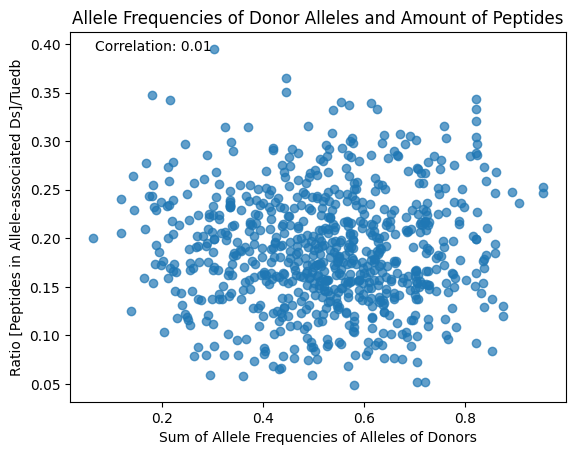

In [112]:
donor_allele_frequency = []
rel_no_peptides = []

plot1 = plot[2]

for donor in plot1:
    rel_no_peptides.append(plot1[donor]['tdb and mono'] / result_dict[donor]['overall peptides in tuedb'])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

fig, ax = plt.subplots()
sc = ax.scatter(donor_allele_frequency, rel_no_peptides, alpha=0.7)

plt.xlabel('Sum of Allele Frequencies of Alleles of Donors')
plt.ylabel('Ratio [Peptides in Allele-associated Ds]/Tuedb')
plt.title('Allele Frequencies of Donor Alleles and Amount of Peptides')

correlation = np.corrcoef(donor_allele_frequency, rel_no_peptides)[0, 1]
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()



### Boxplot: Accuracies across Categories

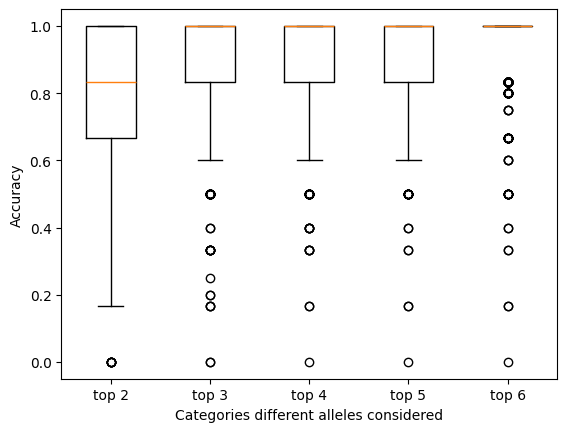

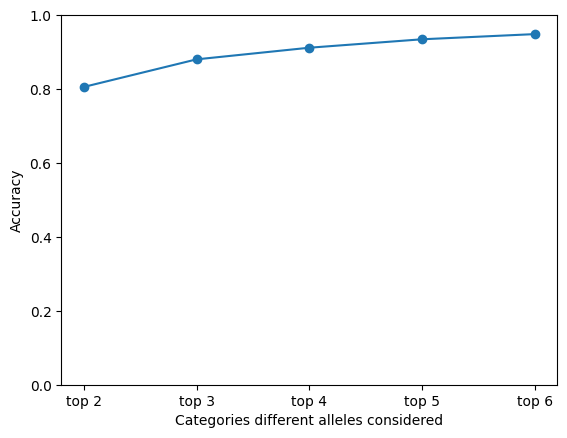

In [113]:
categories = ['top 2', 'top 3', 'top 4', 'top 5', 'top 6']

data = []

for donor in plot[2]:
    data += [[plot[2][donor]['how good'], plot[3][donor]['how good'], plot[4][donor]['how good'], plot[5][donor]['how good'],plot[6][donor]['how good']]]
transposed_data = list(zip(*data))

bp = plt.boxplot(transposed_data)
plt.xticks(range(1, len(categories) + 1), categories)
plt.xlabel('Categories different alleles considered')
plt.ylabel('Accuracy')
plt.show()

transposed_data = list(zip(*data))
means = [np.mean(topx) for topx in transposed_data]

# plot it with line with dots
plt.ylim((0.0,1.0))
plt.plot(categories, means, 'o-')
plt.xlabel('Categories different alleles considered')
plt.ylabel('Accuracy')
#plt.title('Line Plot of Accuracy Across Categories')
plt.show()
